![](https://images.aicrowd.com/raw_images/challenges/banner_file/1020/d25db945a27379961cea.png)

<h2><center> Getting Started with Mask Recognition Challenge</center></h2>

In this puzzle, we have detect mask type and bounding box of the mask from the image of human face. 

In this notebook, we'll use the naive approach to prepare the baseline for this puzzle. 


Naive Approach
---

*   We will create bounding box that will detect the face and crop the image as per the co-ordinates of bounding box from image. 
*   Once we've the cropped image(It'll have the image of mask), we'll feed the data to train classifier which will classify the mask.





# Setting up Environment

### Downloading Dataset

So we will first need to download the python library by AIcrowd that will allow us to download the dataset by just inputting the API key. 

In [ ]:
%%capture
!pip install aicrowd-cli

%load_ext aicrowd.magic


## Login to AIcrowd ㊗¶


In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/CuH2t5beAhrhnUwmpbKoFbF7i3Mp6qFD6Fr73un1CA0
API Key valid
Gitlab access token valid
Saved details successfully!



## Download Dataset¶

We will create a folder name data and download the files there.


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c mask-prediction -o data

sample_submission.csv:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/115M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/193k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/318M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/82.8k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/137M [00:00<?, ?B/s]

In [ ]:
!unzip data/train.zip -d data/ > /dev/null
!unzip data/val.zip -d data/ > /dev/null
!unzip data/test.zip -d data/ > /dev/null

# Importing Libraries

In [ ]:
#Reading the file
import pandas as pd
import numpy as np
import os
from ast import literal_eval

# Image Reading & Preprocessing
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Misc.
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import mimetypes
import argparse
import imutils

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.layers import Input

# Diving in the dataset 🕵️‍♂️

In [ ]:
# define the constant config
class Config:

  # define the input image path
  train_images_path = 'data/train'
  val_images_path = 'data/val'
  test_images_path = 'data/test'

  # define the model hyperparameters
  height, width = 190, 190
  lr = 1e-4
  epochs = 20
  batch_size = 32

# instantiate the config class
config = Config()

In [ ]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")

# evaluate the list column as list, otherwise default as str
train_df['bbox'] = train_df['bbox'].apply(literal_eval)
val_df['bbox'] = val_df['bbox'].apply(literal_eval)

In [ ]:
train_df.head()

,ImageID,bbox,masktype
0,k8o0f,"[73, 197, 293, 400]",N95
1,7a0l9,"[47, 364, 300, 512]",surgical
2,wfp7p,"[203, 221, 380, 403]",N95
3,7qaw6,"[87, 210, 322, 385]",surgical
4,i4kqj,"[227, 283, 479, 475]",surgical


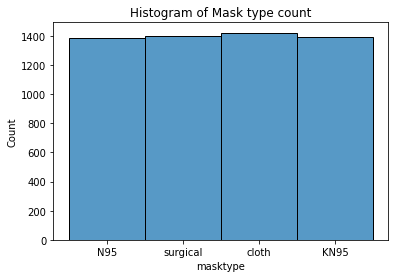

In [ ]:
plt.title('Histogram of Mask type count')
sns.histplot(train_df['masktype'])

In [ ]:
# prepare the map to tranlate the label with a index
mask_map = {}
for idx, m in enumerate(list(train_df['masktype'].unique())):
  mask_map[m] = idx
mask_map

{'KN95': 3, 'N95': 0, 'cloth': 2, 'surgical': 1}

# Image Preprocessing

In this section we are going to learn some opencv functions which can help us detecting the mask from the image!

In [ ]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [ ]:
def plt_imshow_box(title, imagePath, coord):

  # define the function that will wrap box to image
  image = cv2.imread(imagePath)
  # add bbox onto the image
  cv2.rectangle(image, (coord[0], coord[1]), (coord[2], coord[3])
                , (0, 255, 0), 2)
  
  plt_imshow(title, image)

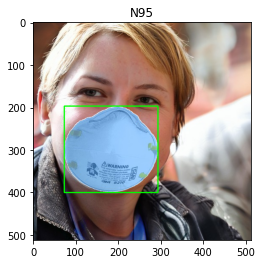

In [ ]:
sample_title = train_df.iloc[0,-1]
sample_image = os.path.join(config.train_images_path, train_df.iloc[0,0] + '.jpg')
sample_box = train_df.iloc[0, 1]

plt_imshow_box(sample_title, sample_image, sample_box)

Preprocessor
----
Prepare data for feeding the model. Get numpy array for image, label and bounding box.

In [ ]:
def image_process(image_path, targe_size):
  image = cv2.imread(image_path)
  original_h, original_w = image.shape[:2]

  # preprocess the image
  image = keras.utils.load_img(image_path, target_size= targe_size)
  image = keras.utils.img_to_array(image)
  image = image/ 255.0
 
  return original_h, original_w, image

In [ ]:
def preprocessor(folder, dataframe, target_size, map):

  # preprocess the dataset from dataframe
  data, label, bbox = [], [], []
  df = dataframe.copy()

  # loop through the dataframe
  for idx, row in df.iterrows():
    path = os.path.join(folder, row['ImageID'] + '.jpg')
    original_h, original_w, image = image_process(path, target_size)

    # scale the coordinates according to the image size
    coord = row['bbox']
    x1, a1 = coord[0] / original_w, coord[2] / original_w
    y1, b1 = coord[1] / original_h, coord[3] / original_h

    # one-hot label
    mask = map[row['masktype']]
    one_hot = np.zeros(len(map))
    one_hot[mask] = 1

    data.append(image)
    label.append(one_hot)
    bbox.append((x1,y1,a1,b1))
  
  # transform the list into np.array to fit in the model
  data = np.array(data, dtype="float32")
  label = np.array(label)
  bbox = np.array(bbox, dtype="float32")

  return data, label, bbox

In [ ]:
#prepare for training
train_data, train_label, train_bbox = preprocessor(config.train_images_path,
                                                   train_df, 
                                                   (config.height, config.width),
                                                   mask_map)

In [ ]:
#prepare for validation
val_data, val_label, val_bbox = preprocessor(config.val_images_path,
                                             val_df, 
                                             (config.height, config.width),
                                             mask_map)

In [ ]:
train_data.shape, val_data.shape

((5600, 190, 190, 3), (2400, 190, 190, 3))

# Model

As for object detection, we use VGG16.

In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = keras.applications.VGG16(weights="imagenet", 
                               include_top=False,
                               input_tensor=Input(shape=(config.height, config.width, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = keras.layers.Flatten()(flatten)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# add on the vgg results
# bbox
bbox_addon = keras.layers.Dense(128, activation = 'relu')(flatten)
bbox_addon = keras.layers.Dense(64, activation = 'relu')(bbox_addon)
bbox_addon = keras.layers.Dense(32, activation = 'relu')(bbox_addon)
bbox_addon = keras.layers.Dense(4, activation = 'sigmoid', 
                                name = 'box_final')(bbox_addon)

# label
label_addon = keras.layers.Dense(512, activation = 'relu')(flatten)
label_addon = keras.layers.Dropout(0.5)(label_addon)
label_addon = keras.layers.Dense(64, activation = 'relu')(label_addon)
label_addon = keras.layers.Dropout(0.5)(label_addon)
label_addon = keras.layers.Dense(4, activation = 'softmax', 
                                name = 'label_final')(label_addon)

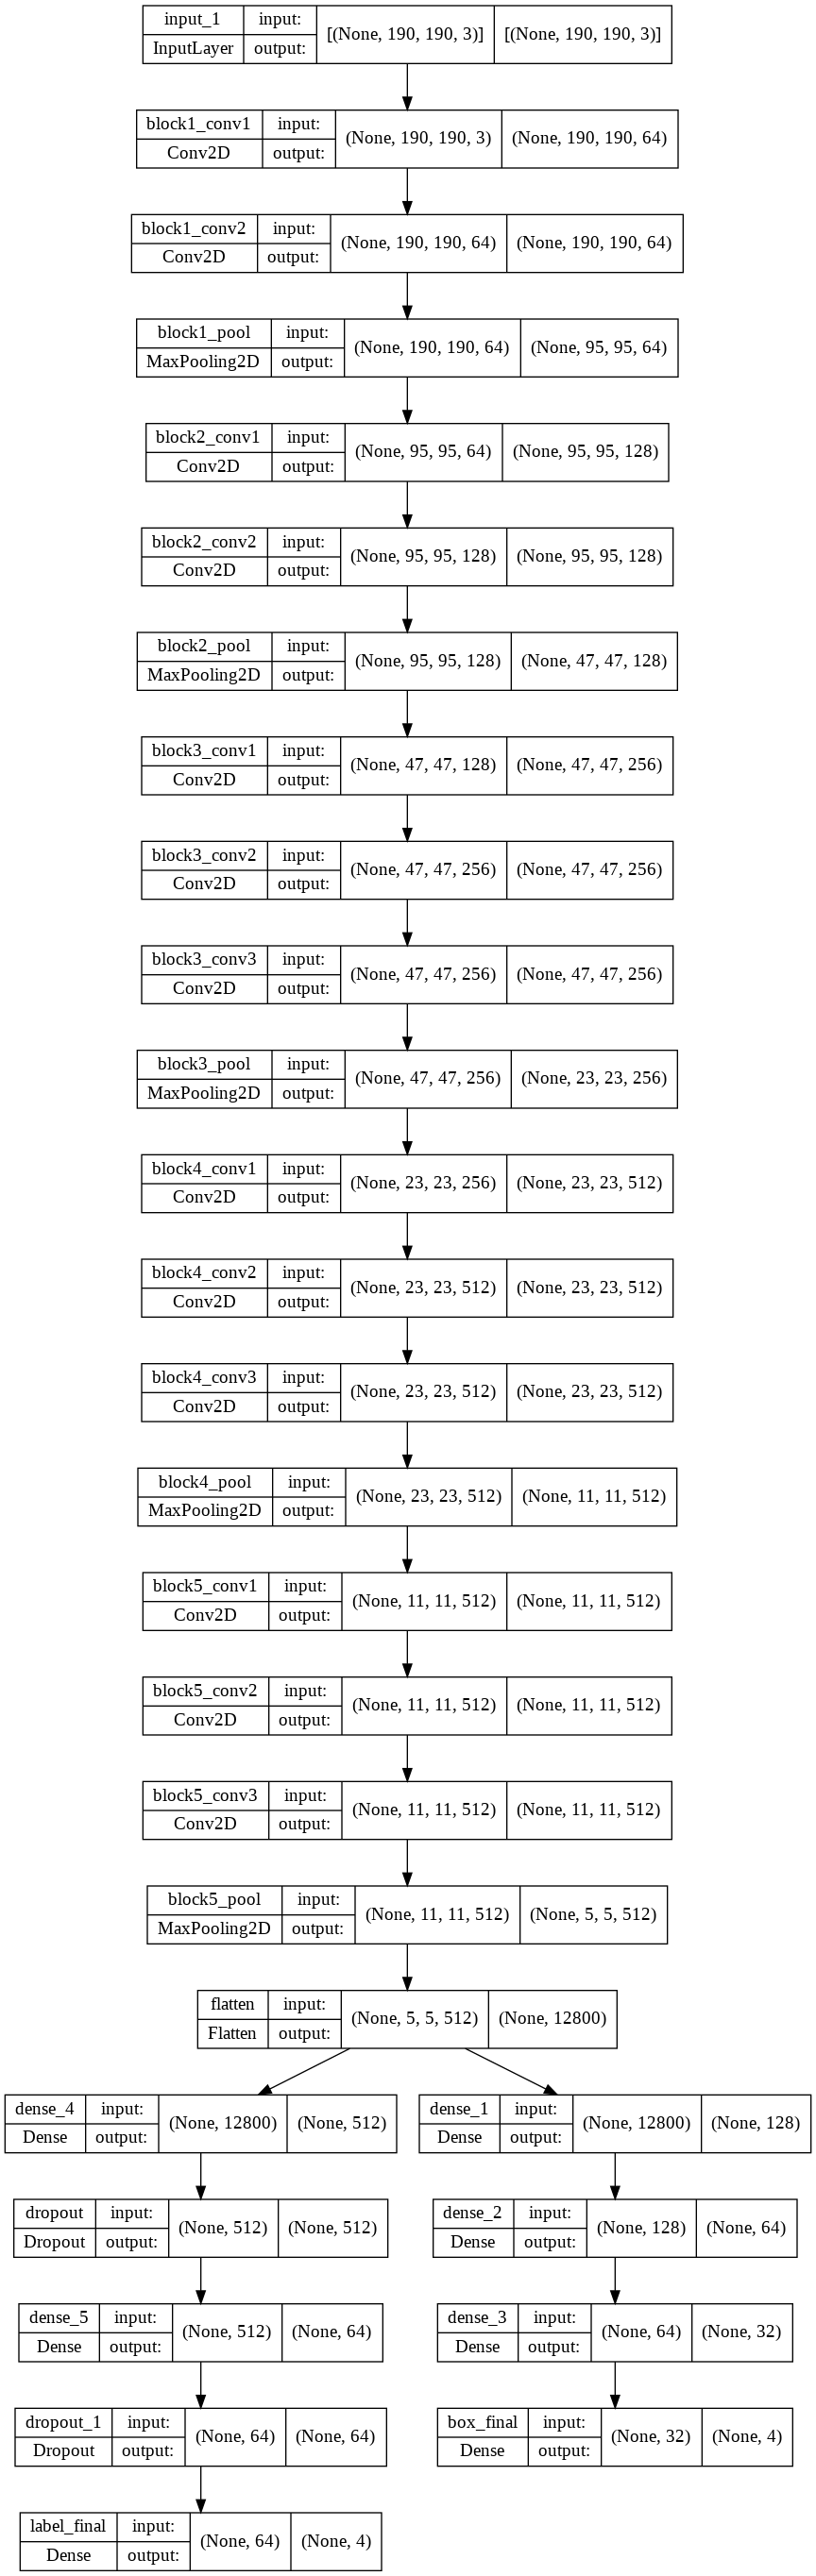

In [ ]:
# add those to output to the VGG
model = keras.models.Model(
	inputs=vgg.input,
	outputs=(bbox_addon, label_addon))

# print the schema
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"label_final": "categorical_crossentropy",
	"box_final": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"label_final": 1.0,
	"box_final": 1.0
}

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

# initialize the optimizer, compile the model, and show the model
# summary
opt = keras.optimizers.Adam(learning_rate=config.lr)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"],
    loss_weights=lossWeights)

In [ ]:
# construct a dictionary for our target training outputs
trainTargets = {
	"label_final": train_label,
	"box_final": train_bbox
}

# construct a second dictionary, this one for our target testing
# outputs
valTargets = {
	"label_final": val_label,
	"box_final": val_bbox
}

In [ ]:
hist1 = model.fit(train_data, trainTargets
                  , validation_data = (val_data, valTargets)
                  , epochs=config.epochs
                  , batch_size = config.batch_size
                  , callbacks=[early_stopping_cb])

Epoch 1/20
175/175 [==============================] - 31s 111ms/step - loss: 1.1654 - box_final_loss: 0.0079 - label_final_loss: 1.1574 - box_final_accuracy: 0.8416 - label_final_accuracy: 0.4759 - val_loss: 0.5662 - val_box_final_loss: 0.0028 - val_label_final_loss: 0.5634 - val_box_final_accuracy: 0.9179 - val_label_final_accuracy: 0.8533
Epoch 2/20
175/175 [==============================] - 16s 94ms/step - loss: 0.6133 - box_final_loss: 0.0022 - label_final_loss: 0.6112 - box_final_accuracy: 0.9268 - label_final_accuracy: 0.7650 - val_loss: 0.3217 - val_box_final_loss: 0.0020 - val_label_final_loss: 0.3197 - val_box_final_accuracy: 0.9304 - val_label_final_accuracy: 0.9021
Epoch 3/20
175/175 [==============================] - 15s 88ms/step - loss: 0.4272 - box_final_loss: 0.0014 - label_final_loss: 0.4258 - box_final_accuracy: 0.9382 - label_final_accuracy: 0.8386 - val_loss: 0.2543 - val_box_final_loss: 0.0018 - val_label_final_loss: 0.2525 - val_box_final_accuracy: 0.9267 - val_la

In [ ]:
# save the model to disk
model.save('vgg_addon.h5', save_format="h5")

## Visualize the model loss

In [ ]:
loss_type = ['loss', 'box_final_loss', 'label_final_loss',
             'val_loss', 'val_box_final_loss', 'val_label_final_loss']
acc_type = ['box_final_accuracy', 'label_final_accuracy', 
            'val_box_final_accuracy', 'val_label_final_accuracy']

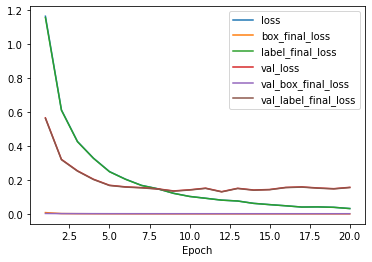

In [ ]:
loss_record = []
for i in loss_type:
  temp_loss = hist1.history[i]
  loss_record.append(temp_loss)

loss_record = pd.DataFrame(loss_record, index = loss_type).T
loss_record.index = list(range(1, config.epochs+1))
loss_record.index.name = 'Epoch'

loss_record.plot()

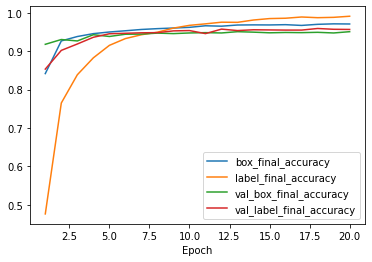

In [ ]:
acc_record = []
for i in acc_type:
  temp_loss = hist1.history[i]
  acc_record.append(temp_loss)

acc_record = pd.DataFrame(acc_record, index = acc_type).T
acc_record.index = list(range(1, config.epochs+1))
acc_record.index.name = 'Epoch'

acc_record.plot()

# Submitting Results 📄

In [ ]:
# prepare test dataset
test_df = pd.DataFrame()
n_test_image = os.listdir(config.test_images_path)
test_df['ImageID'] = [img_name.split(".")[0] for img_name in n_test_image]
test_df.head()

,ImageID
0,hm3nl
1,6bbrv
2,1sa11
3,astz6
4,iaxwc


In [ ]:
# prepare label
mask_map =  {k: v for k, v in sorted(mask_map.items(), key=lambda item: item[1])}
mask_key = list(mask_map.keys())
mask_key

['N95', 'surgical', 'cloth', 'KN95']

In [ ]:
def get_test_result(df_original, folder, target_size, key_list, model):

  df = df_original.copy()

  labels, bboxes = [], []
  for idx, r in df.iterrows():
    
    # Reading the test image
    image_id = r['ImageID']
    image_path = os.path.join(folder, image_id+'.jpg')
    original_h, original_w, image = image_process(image_path, target_size)
    image = image[np.newaxis, ...]

    # Generating the bounding boxes
    (box, label) = model.predict(image)
    (x1, y1, a1, b1) = box[0]

    # find the label based one hot
    labels.append(key_list[label.argmax()])

    # find bbox in orginal scale
    x1, a1  = int(x1 * original_w), int(a1 * original_w)
    y1, b1  = int(y1 * original_h), int(b1 * original_h)
    bboxes.append([x1, y1, a1, b1])
  
  df['bbox'] = bboxes
  df['masktype'] = labels
  return df

In [ ]:
test_df_final = get_test_result(test_df, config.test_images_path, 
                                (config.height, config.width), mask_key, model)

In [ ]:
test_df_final.head()

,ImageID,bbox,masktype
0,hm3nl,"[274, 180, 480, 417]",N95
1,6bbrv,"[135, 320, 379, 503]",N95
2,1sa11,"[193, 220, 455, 384]",KN95
3,astz6,"[190, 357, 433, 507]",cloth
4,iaxwc,"[350, 220, 507, 369]",cloth


In [ ]:
!rm -rf assets
!mkdir assets

test_df_final.to_csv(os.path.join("assets", "submission.csv"), index=False)

**Note : Please make sure that there should be filename `submission.csv` in `assets` folder before submitting it**

## Uploading the Results

In [ ]:
%aicrowd notebook submit -c mask-prediction -a assets --no-verify

Using notebook: AI_Blix13_03_Mask_Prediction for submission...
Scrubbing API keys from the notebook...


Output()

╭─────────────────────────╮                                                   
                                                  │ Successfully submitted! │                                                   
                                                  ╰─────────────────────────╯

                                                        Important links                                                         
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/submissions/174638              │
│                  │                                                                                                           │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/submissions?my_submissions=true │
│                  │                                                                                                           │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/leaderboards                    │
│                  │                                                                                                           │
│ Discussion forum │ https://discourse.aicrowd.com/c/ai-blitz-xiii                                                             │
│                  │                                                                                                           │
│   Challenge page │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction                                 │
└──────────────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────┘